In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng


Using TensorFlow backend.


In [2]:
train_folder = "/Users/rld1996/Downloads/omniglot/images_background/"
val_folder = '/Users/rld1996/Downloads/omniglot/images_evaluation/'
save_path = '/Users/rld1996/Downloads/omniglot/data/'

In [67]:
#function to perform pca n images
def doPCA(img,n=60):
    
    pca=PCA(n_components=n)
    principalComponents = pca.fit_transform(img)
    print(pca.explained_variance_ratio_)
    return principalComponents

In [68]:
#does pca. and scaling
def preprocess(X):
    n,ex,w,h=X.shape
    x=X.reshape((n*ex,w*h))
    x=scaleData(x)
    x=doPCA(x)
   
    
    return x

In [69]:
#performs scaling
def scaleData(img):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(img)
    return img

In [3]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    
    X = np.stack(X)

    return X,y,lang_dict

In [4]:
X,y,c=loadimgs(train_folder)

loading alphabet: Gujarati


/Users/rld1996/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Grantha
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Balinese
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Burmese_(Myanmar)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Latin
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: Japanese_(hiragana)
loading alphabet: Tagalog
loading alphabet: Greek
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(katakana)
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Armenian
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Cyrillic
loading alphabet: Bengali
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)


In [5]:
print(np.shape(X))

(964, 20, 105, 105)


In [6]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

In [7]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Oriya


/Users/rld1996/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: ULOG
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Atlantean
loading alphabet: Keble
loading alphabet: Manipuri
loading alphabet: Gurmukhi
loading alphabet: Tibetan
loading alphabet: Aurek-Besh
loading alphabet: Ge_ez
loading alphabet: Angelic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Kannada
loading alphabet: Avesta
loading alphabet: Mongolian
loading alphabet: Syriac_(Serto)
loading alphabet: Atemayar_Qelisayer
loading alphabet: Sylheti
loading alphabet: Glagolitic


In [8]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)


In [9]:
def initialize_weights(shape, name=None):
    #initialize layer weights with mean as 0.0 and standard deviation of 0.01

    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [70]:
def initialize_bias(shape, name=None):
    # initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01

    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [71]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [66]:
model = get_siamese_model((105, 105, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

In [13]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [14]:

with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
     v
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)']


In [15]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic']


In [16]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [18]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [19]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [20]:
def train():
    evaluate_every = 200 # interval for evaluating on one-shot tasks
    batch_size = 32
    n_iter = 20000 # No. of training iterations
    N_way = 20 # how many classes for testing one-shot tasks
    n_val = 250 # how many one-shot tasks to validate on
    best = -1
    model_path = 'weights/'
    i=0
    model.save(os.path.join(model_path, 'weights.{}.h5'.format(i)))
    print("Starting training process!")
    print("-------------------------------------")
    t_start = time.time()
    for i in range(lost, n_iter+1):


        (inputs,targets) = get_batch(batch_size)
        loss = model.train_on_batch(inputs, targets)
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
            print("Train Loss: {0}".format(loss)) 
            val_acc = test_oneshot(model, N_way, n_val, verbose=True)
            model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                best = val_acc

In [21]:
model_path='weights/'
model.load_weights(os.path.join(model_path, "weights.10000.h5"))

In [22]:
ways = np.arange(2,22,2)
resume =  False
trials = 50

In [23]:
val_accs, train_accs = [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))

Evaluating model on 50 random 2 way one-shot learning tasks ... 

Got an average of 98.0% 2 way one-shot learning accuracy 

Evaluating model on 50 random 2 way one-shot learning tasks ... 

Got an average of 100.0% 2 way one-shot learning accuracy 

Evaluating model on 50 random 4 way one-shot learning tasks ... 

Got an average of 94.0% 4 way one-shot learning accuracy 

Evaluating model on 50 random 4 way one-shot learning tasks ... 

Got an average of 96.0% 4 way one-shot learning accuracy 

Evaluating model on 50 random 6 way one-shot learning tasks ... 

Got an average of 88.0% 6 way one-shot learning accuracy 

Evaluating model on 50 random 6 way one-shot learning tasks ... 

Got an average of 98.0% 6 way one-shot learning accuracy 

Evaluating model on 50 random 8 way one-shot learning tasks ... 

Got an average of 74.0% 8 way one-shot learning accuracy 

Evaluating model on 50 random 8 way one-shot learning tasks ... 

Got an average of 92.0% 8 way one-shot learning accuracy 


In [24]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs),f)

In [23]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs) = pickle.load(f)

In [24]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [25]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [63]:
pairs, targets = make_oneshot_task(16,"train","Sanskrit")

In [ ]:
#kernel dies
#plot_oneshot_task(pairs)
try:
    fig,ax = plt.subplots(1)
    ax.plot(ways, val_accs, "m", label="Siamese(val set)")
    ax.plot(ways, train_accs, "y", label="Siamese(train set)")


    ax.plot(ways, 100.0/ways, "g", label="Random guessing")
    plt.xlabel("Number of possible classes in one-shot tasks")
    plt.ylabel("% Accuracy")
    plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    inputs,targets = make_oneshot_task(20, "val", 'Oriya')
    plt.show()
except:
    print("Failed")



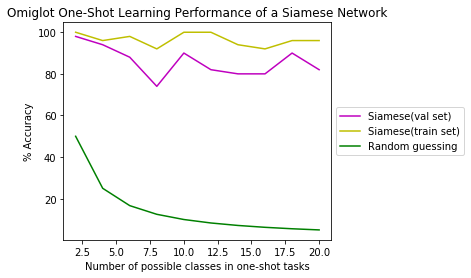

In [65]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

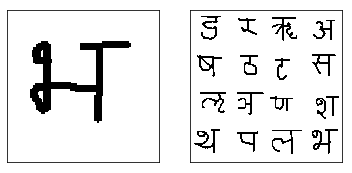

In [64]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
img = concat_images(pairs[1])
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.matshow(img,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

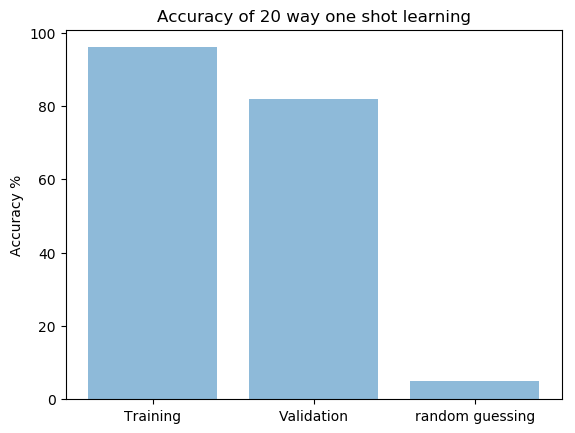

In [74]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Training','Validation','random guessing')
y_pos = np.arange(len(objects))
performance = [train_accs[len(train_accs)-1],val_accs[len(val_accs)-1],100/20]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy %')
plt.title('Accuracy of 20 way one shot learning')
 
plt.show()


In [59]:
pairs[0].shape

(16, 105, 105, 1)

In [75]:
print('The output accuracy is pretty good. The accuracy can be further improved by performing affine transformation on the input and increasing the number of epochs')

The output accuracy is pretty good. The accuracy can be further improved by performing affine transformation on the input and increasing the number of epochs


In [76]:
print('I tried performing PCA on the inoput images in order to capture more variance in less dimensions. But individual vectors are not able to capture more variance so it does not make that much difference')

I tried performing PCA on the inoput images in order to capture more variance in less dimensions. But individual vectors are not able to capture more variance so it does not make that much difference
